# Notebook: Investigation of block 5 anomalies

Perform different analysis methods on Block 5, branches comparisons per fill, chi squared matrix computations, generation of interactive histograms of all branches of split block 5 ROOT files, after fitting them and computing sWeights.

- **Input:** raw block 5 ROOT files (`B2CC` and `B2OC`, variants A/B).  
- **Output:** `B5_outputs/` with two subfolders:  
  - **fit_plots/** → PNG mass fit plots  
  - **histograms/** → interactive Plotly HTML histograms of all branches 
- **File rewriting:** each input ROOT file is updated in place with branch `sw_sig`; backups `<file>.bak` are kept.  

# **I. Shape comparison of distributions per fill**


PID histogram overlay tool (B2OC/B2CC).

- Reads selected branches from a list of ROOT files.
- Produces per branch overlaid normalized histograms across files,
  with per bin error bars based on sum of weights^2.
- Provides a dropdown to switch branches, and buttons to toggle error bars.
- Saves two standalone HTML files: one for B2OC and one for B2CC.

In [1]:
from pathlib import Path
%pip install plotly
%pip install pandas

# Base output folders 
OUT_BASE = Path.cwd() / "data/block5_analysis/outputs"
DIR_FITS = OUT_BASE / "fit_plots"
DIR_HISTS = OUT_BASE / "histograms"

for d in (DIR_FITS, DIR_HISTS):
    d.mkdir(parents=True, exist_ok=True)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, platform
from collections import defaultdict
from typing import Dict, List, Tuple
import numpy as np
import plotly.graph_objects as go
import uproot
from pathlib import Path
import glob

PATTERN = "./data/block5_analysis/2024_*_B5_F*.root" 

file_paths = sorted(str(p) for p in glob.glob(PATTERN))


b2oc_tree = "ST-b2oc"
b2cc_tree = "ST-b2cc"

b2oc_branches = [
    "Kp_TRCHI2", "Kp_PID_K", "Kp_PROBNN_K", "Kp_PROBNN_PI",
    "pim_TRCHI2", "pim_PID_K", "pim_PROBNN_K", "pim_PROBNN_PI",
    "pip_TRCHI2", "pip_PID_K", "pip_PROBNN_K", "pip_PROBNN_PI",
]
b2cc_branches = [
    "mup_TRCHI2","mup_PID_MU","mup_PROBNN_MU",
    "mum_TRCHI2","mum_PID_MU","mum_PROBNN_MU",
    "Kp_TRCHI2","Kp_PID_K","Kp_PROBNN_K","Kp_PROBNN_PI",
]

colors = ["red","blue","green","orange","purple","cyan","magenta","brown"]

# Output paths
out_b2cc = str(DIR_HISTS / "2024_B5_b2cc_pid_histograms_branch_toggle.html")
out_b2oc = str(DIR_HISTS / "2024_B5_b2oc_pid_histograms_branch_toggle.html")


# File Reading 


def read_file_branches(path, tree_name, branches):
    """
    input: the path to the files, the tree names and the selected branches
    Returns {branch: np.ndarray} for the given file/tree.
    """
    out = {}
    try:
        with uproot.open(path) as f:
            if tree_name not in f:
                print(f"Tree '{tree_name}' not found in {os.path.basename(path)}")
                return out
            tree = f[tree_name]
            available = set(tree.keys())

            # Filter to branches that actually exist
            wanted = [b for b in branches if b in available]

            missing = sorted(set(branches) - set(wanted))
            if missing:
                print(f"Missing in {os.path.basename(path)}: {', '.join(missing)}")
            if not wanted:
                return out

            arrays = tree.arrays(wanted, library="np")

            for b in wanted:
                arr = arrays[b]
                if arr is None:
                    print(f"Branch '{b}' has no data")
                    continue
                # Flatten so it handles jagged and remove non finites
                data = np.asarray(arr).ravel()
                data = data[np.isfinite(data)]
                out[b] = data
    except Exception as e:
        print(f"Failed {os.path.basename(path)}: {e}")
    return out



# Plot Builder


def build_figure(category_name, branches, files, data_by_file, default_branch=None):
    """
    Create a plotly Figure where traces are grouped by branch.
    For each branch, we add one Bar per file (overlayed).

    Histograms are normalized to density.
    Error bars are based on sqrt(N) counting statistics only.
    """
    # pick a default branch that actually exists
    if default_branch is None:
        for b in branches:
            if any(b in data_by_file[fname] for _, fname in files):
                default_branch = b
                break

    fig = go.Figure()
    traces_per_branch = []

    for b in branches:
        present = []
        mins, maxs = [], []
        for i, (_, fname) in enumerate(files):
            if b in data_by_file[fname]:
                data = data_by_file[fname][b]
                if data.size == 0:
                    continue
                present.append((i, fname))
                mins.append(np.min(data))
                maxs.append(np.max(data))

        if not present:
            traces_per_branch.append(0)
            continue

        all_min = float(np.min(mins))
        all_max = float(np.max(maxs))
        if not np.isfinite(all_min) or not np.isfinite(all_max) or all_min == all_max:
            all_min = (all_min if np.isfinite(all_min) else 0.0) - 0.5
            all_max = (all_max if np.isfinite(all_max) else 0.0) + 0.5


        bins = np.linspace(all_min, all_max, 101)  
        centers = 0.5 * (bins[1:] + bins[:-1])
        bin_width = bins[1] - bins[0]

        count_in_group = 0
        for i, fname in present:
            data = data_by_file[fname][b]

            counts, _ = np.histogram(data, bins=bins, density=False)
            sumw2 = counts  # since weights=None
            Wtot = float(data.size)

            if Wtot <= 0 or bin_width <= 0:
                continue

            y_density   = counts / (Wtot * bin_width)
            err_density = np.sqrt(sumw2) / (Wtot * bin_width)

            fig.add_trace(go.Bar(
                x=centers,
                y=y_density,
                name=fname,
                marker=dict(color=colors[i % len(colors)]),
                opacity=0.5,
                width=bin_width,
                visible=False,
                error_y=dict(
                    type="data",
                    array=err_density,
                    visible=True,  
                    color="black",
                    thickness=1,
                    width=0         
                )
            ))
            count_in_group += 1

        traces_per_branch.append(count_in_group)


    n_traces = sum(traces_per_branch)
    branch_offsets = np.cumsum([0] + traces_per_branch[:-1])

    buttons = []
    for b, start, count in zip(branches, branch_offsets, traces_per_branch):
        vis = [False] * n_traces
        for j in range(start, start + count):
            vis[j] = True
        buttons.append(dict(
            label=b,
            method="update",
            args=[
                {"visible": vis},
                {"title": f"{category_name}: Histograms of {b}",
                 "xaxis": {"title": b},
                 "yaxis": {"title": "Normalized counts (density)"},
                 "legend": {"title": "Files"}}
            ]
        ))


    if default_branch in branches:
        k = branches.index(default_branch)
        start, count = branch_offsets[k], traces_per_branch[k]
        for j in range(start, start + count):
            fig.data[j].visible = True
        xlab = default_branch
    else:
        xlab = ""

    bar_trace_indices = list(range(n_traces))

    # layout with TWO menus: (1) branch dropdown, (2) error-bar toggle buttons
    fig.update_layout(
        title=f"{category_name}: Histograms of {default_branch}",
        xaxis_title=xlab,
        yaxis_title="Normalized counts (density)",
        legend_title="Files",
        barmode="overlay",
        template="plotly_white",
        updatemenus=[
            dict(  # Branch selector
                type="dropdown",
                x=1.0, xanchor="right",
                y=1.15, yanchor="top",
                buttons=buttons,
                showactive=True
            ),
            dict(  # Error-bar ON/OFF
                type="buttons",
                direction="right",
                x=0.0, xanchor="left",
                y=1.1, yanchor="top",
                buttons=[
                    dict(label="Error bars: ON",
                         method="restyle",
                         args=[{"error_y.visible": True}, bar_trace_indices]),
                    dict(label="OFF",
                         method="restyle",
                         args=[{"error_y.visible": False}, bar_trace_indices]),
                ]
            )
        ]
    )
    return fig


# Main Execution of the functions
data_store = {
    "B2OC": {"tree": b2oc_tree, "branches": b2oc_branches, "files": [], "data": defaultdict(dict)},
    "B2CC": {"tree": b2cc_tree, "branches": b2cc_branches, "files": [], "data": defaultdict(dict)},
}

for path in file_paths:
    fname = os.path.basename(path)
    if "B2OC" in fname:
        cat = "B2OC"
    elif "B2CC" in fname:
        cat = "B2CC"
    else:
        print(f"Skipping unknown file: {fname}")
        continue

    tree = data_store[cat]["tree"]
    branches = data_store[cat]["branches"]
    branch_data = read_file_branches(path, tree, branches)

    if branch_data:
        data_store[cat]["files"].append((path, fname))
        data_store[cat]["data"][fname] = branch_data

b2oc_fig = build_figure("B2OC",
                        data_store["B2OC"]["branches"],
                        data_store["B2OC"]["files"],
                        data_store["B2OC"]["data"])

b2cc_fig = build_figure("B2CC",
                        data_store["B2CC"]["branches"],
                        data_store["B2CC"]["files"],
                        data_store["B2CC"]["data"])

b2cc_fig.write_html(out_b2cc)
b2oc_fig.write_html(out_b2oc)

print(f"Saved B2CC figure to: {out_b2cc}")
print(f"Saved B2OC figure to: {out_b2oc}")

b2cc_fig.show()
b2oc_fig.show()

Saved B2CC figure to: /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/2024_B5_b2cc_pid_histograms_branch_toggle.html
Saved B2OC figure to: /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/2024_B5_b2oc_pid_histograms_branch_toggle.html


# **II. Pairwise reduced $\chi^2$ comparison between fills**

Pairwise χ² comparison tool (B2OC/B2CC).

- Computes χ² between histograms of a chosen branch across all files in a category.
- Produces symmetric matrices of reduced χ², p-values, χ², ndf, and α (by hovering on the values you can see them)
- Provides an interactive widget with dropdowns for category and branch, a slider for binning, and mode toggle (shape vs counts).
- Displays an interactive Plotly heatmap of χ²/ndf with hover details for each file pair.

In [3]:
import re
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import chi2 as _chi2
from typing import Optional


# Shared styling 


# Heatmap range and colors
ZMIN, ZMAX = 0.5, 1.5

def _norm(v: float) -> float:
    """Map [ZMIN, ZMAX] -> [0, 1] for the heatmap colorscale."""
    return (v - ZMIN) / (ZMAX - ZMIN)

COLOR_SCALE = [
    [_norm(0.50), "#8b0000"],  # red 
    [_norm(0.60), "#ff8c00"],  # orange 
    [_norm(0.70), "#ffe082"],  # yellow 
    [_norm(1.00), "#2ca25f"],  # green  
    [_norm(1.30), "#ffe082"],  # yellow 
    [_norm(1.40), "#ff8c00"],  # orange 
    [_norm(1.50), "#8b0000"],  # deep red
]


# Core helpers

def _finite_bins_from_data(xA: np.ndarray, xB: np.ndarray, nbins: int) -> np.ndarray:
    """
    Build a common binning from the combined data ranges of xA and xB.
    Falls back to a ±0.5 window if the range is degenerate or non finite.
    """
    lo = float(min(np.min(xA), np.min(xB)))
    hi = float(max(np.max(xA), np.max(xB)))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo = (lo if np.isfinite(lo) else -0.5) - 0.5
        hi = (hi if np.isfinite(hi) else  0.5) + 0.5
    return np.linspace(lo, hi, nbins + 1)

def _safe_sumw2(x: np.ndarray, bins: np.ndarray) -> np.ndarray:
    """
    Per bin variance estimate for the data = counts.
    """
    s2, _ = np.histogram(x, bins=bins, weights=None, density=False)
    return s2.astype(float)

def _hist_counts(x: np.ndarray, bins: np.ndarray) -> np.ndarray:
    """Per bin counts for the data."""
    c, _ = np.histogram(x, bins=bins, density=False)
    return c.astype(float)

def _alpha_for_mode(cA: np.ndarray, cB: np.ndarray, mode: str) -> float:
    """
    Overall normalization between histograms:
      - 'shape'  : free scale α = sumA/sumB
      - 'counts' : fixed α = 1
    """
    if mode == "shape":
        SA, SB = float(np.sum(cA)), float(np.sum(cB))
        return SA / SB if SB != 0 else np.nan
    return 1.0

def _extract_fill(fname: str) -> Optional[int]:
    """Extract integer fill number from a filename pattern."""
    m = re.search(r"F(\d+)", fname)
    return int(m.group(1)) if m else None


# χ² calculator

def chi2_two_hists(
    xA: np.ndarray,
    xB: np.ndarray,
    nbins: int = 100,
    bins: Optional[np.ndarray] = None,
    mode: str = "counts",
):
    """
    χ² comparison between two histograms.

    Parameters
    ----------
    xA, xB : np.ndarray
        Sample arrays.
    nbins : int
        Number of bins if 'bins' is not provided.
    bins : np.ndarray | None
        Explicit bin edges; if None, built from combined range of xA and xB.
    mode : {'counts', 'shape'}
        'counts' uses α=1; 'shape' fits an overall scale α = sumA/sumB.

    Returns
    -------
    dict with keys: chi2, ndf, red, p, alpha, bins_used
    """
    if xA.size == 0 or xB.size == 0:
        return dict(chi2=np.nan, ndf=0, red=np.nan, p=np.nan, alpha=np.nan, bins_used=0)

    if bins is None:
        bins = _finite_bins_from_data(xA, xB, nbins)

    cA = _hist_counts(xA, bins)
    cB = _hist_counts(xB, bins)
    s2A = _safe_sumw2(xA, bins)
    s2B = _safe_sumw2(xB, bins)

    alpha = _alpha_for_mode(cA, cB, mode)
    diff  = cA - alpha * cB
    var   = s2A + (alpha**2) * s2B

    mask = var > 0
    nb   = int(np.count_nonzero(mask))
    if nb == 0 or not np.isfinite(alpha):
        return dict(chi2=np.nan, ndf=0, red=np.nan, p=np.nan, alpha=alpha, bins_used=0)

    chi2 = float(np.sum((diff[mask]**2) / var[mask]))
    ndf  = nb - (1 if mode == "shape" else 0)
    red  = chi2/ndf if ndf > 0 else np.nan
    p    = _chi2.sf(chi2, ndf) if ndf > 0 else np.nan

    return dict(chi2=chi2, ndf=ndf, red=red, p=p, alpha=alpha, bins_used=nb)

#Pairwise comparison 

def pairwise_matrix(data_store: dict, category: str, branch: str, nbins: int = 100, mode: str = "shape"):
    """
    Build symmetric matrices of reduced χ², p-values, χ², ndf, and α
    for all file pairs that contain the requested branch within a category.

    Binning is common to all files (global min/max over files, nbins bins).
    Returns (labels, red, pvl, chi, ndf, alp) or None if no files with that branch.
    """
    files = [fname for _, fname in data_store[category]["files"]]
    files = [f for f in files if branch in data_store[category]["data"][f]]

    # Sort by fill number when available
    fills = {f: _extract_fill(f) for f in files}
    files = sorted(files, key=lambda x: (fills[x] is None, fills[x] if fills[x] is not None else x))

    # Global bins for this branch
    mins, maxs = [], []
    for f in files:
        arr = data_store[category]["data"][f][branch]
        if arr.size:
            mins.append(np.min(arr))
            maxs.append(np.max(arr))
    if not mins:
        return None

    lo, hi = float(np.min(mins)), float(np.max(maxs))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = (lo if np.isfinite(lo) else -0.5) - 0.5, (hi if np.isfinite(hi) else 0.5) + 0.5
    bins = np.linspace(lo, hi, nbins + 1)

    n = len(files)
    red = np.full((n, n), np.nan)
    pvl = np.full((n, n), np.nan)
    chi = np.full((n, n), np.nan)
    ndf = np.zeros((n, n), dtype=int)
    alp = np.full((n, n), np.nan)

    # Fill upper triangle (and mirror)
    for i, fi in enumerate(files):
        xi = data_store[category]["data"][fi][branch]
        for j, fj in enumerate(files[i:], start=i):
            xj = data_store[category]["data"][fj][branch]
            res = chi2_two_hists(xi, xj, nbins=nbins, bins=bins, mode=mode)
            red[i, j] = red[j, i] = res["red"]
            pvl[i, j] = pvl[j, i] = res["p"]
            chi[i, j] = chi[j, i] = res["chi2"]
            ndf[i, j] = ndf[j, i] = res["ndf"]
            alp[i, j] = alp[j, i] = res["alpha"]

    labels = [str(_extract_fill(f)) if _extract_fill(f) is not None else f for f in files]
    return labels, red, pvl, chi, ndf, alp

# Widget UI

def chi2_matrix_widget(data_store: dict, default_category: str = "B2OC", default_bins: int = 100):
    """
    Interactive widget:
      - Pick category, branch, number of bins, and comparison mode.
      - Displays a heatmap of reduced χ².
    """
    # Controls
    cat_dd    = widgets.Dropdown(options=list(data_store.keys()), value=default_category, description="Category:")
    branch_dd = widgets.Dropdown(options=[], description="Branch:")
    bins_sl   = widgets.IntSlider(value=default_bins, min=30, max=200, step=10, description="Bins:")
    mode_tb   = widgets.ToggleButtons(options=[("Shape (α fit)", "shape"), ("Counts (α=1)", "counts")],
                                      value="shape", description="Compare:")
    run_btn   = widgets.Button(description="Compute", button_style="primary")
    out       = widgets.Output()

    # Populate branch dropdown with all branches present
    def refresh_branches(*_):
        cat = cat_dd.value
        files = [fname for _, fname in data_store[cat]["files"]]
        all_b = set()
        for f in files:
            all_b.update(data_store[cat]["data"][f].keys())
        branch_dd.options = sorted(all_b)
        if branch_dd.options:
            branch_dd.value = branch_dd.options[0]

    cat_dd.observe(refresh_branches, names="value")
    refresh_branches()

    def run(_=None):
        cat, br, nb, mode = cat_dd.value, branch_dd.value, int(bins_sl.value), mode_tb.value
        with out:
            clear_output(wait=True)

            if not branch_dd.options:
                print("No branches available in this category.")
                return

            res = pairwise_matrix(data_store, cat, br, nbins=nb, mode=mode)
            if res is None:
                print("No files with that branch.")
                return

            labels, red, pvl, chi, ndf, alp = res

            Z = np.clip(red.copy(), ZMIN, ZMAX)
            np.fill_diagonal(Z, 1.0)  

            text = [['' for _ in labels] for __ in labels]
            for i in range(len(labels)):
                for j in range(len(labels)):
                    if np.isfinite(red[i, j]):
                        text[i][j] = f"{1.00:.2f}" if i == j else f"{red[i,j]:.2f}"

            fig = go.Figure(data=go.Heatmap(
                z=Z, x=labels, y=labels,
                colorscale=COLOR_SCALE, zmin=ZMIN, zmax=ZMAX,
                colorbar=dict(title="χ²/ndf"),
                text=text, texttemplate="%{text}",
                customdata=np.dstack((chi, ndf, pvl, alp)),
                hovertemplate=("A: %{y}  B: %{x}"
                               "<br>χ²/ndf: %{text}"
                               "<br>χ²: %{customdata[0]:.3f}, ndf: %{customdata[1]}"
                               "<br>p: %{customdata[2]:.3g}"
                               "<br>α: %{customdata[3]:.3f}<extra></extra>")
            ))
            fig.update_layout(
                title=f"Pairwise reduced χ² — {cat} · {br} (bins={nb})",
                xaxis_title="Fill", yaxis_title="Fill",
                yaxis=dict(autorange="reversed")
            )
            display(fig)

    run_btn.on_click(run)

    ui = widgets.VBox([
        widgets.HBox([cat_dd, branch_dd, bins_sl, mode_tb, run_btn]),
        out
    ])
    display(ui)

# Execution point

chi2_matrix_widget(data_store, default_category="B2OC", default_bins=100)


# **III. Signal-to-background ratio as a function of fill**

Signal/Background analysis (B2OC/B2CC).

- Parses ROOT files to extract the signal yield (nsig) from the fit_results tree and the total number of entries from the main decay trees.
- Computes background counts (total – signal) and the signal/background ratio for each file.
- Produces a table with category, fill number, total entries, signal events, and signal/background ratio. The table is also saved as HTML file.
- Provides a Matplotlib line plot of the signal/background ratio vs fill number, with separate curves for B2OC and B2CC.

Collected nsig values:
 {'B2CC_F10059': 9109.606405213128, 'B2CC_F10061': 28295.21189025508, 'B2CC_F10066': 33044.34283808159, 'B2CC_F10069': 74926.92605992548, 'B2CC_F10070': 11411.92953814415, 'B2CC_F10072': 71455.56581491827, 'B2CC_F10073': 74379.93156870618, 'B2CC_F10074': 70334.91445539553, 'B2CC_F10075': 18916.979246444822, 'B2CC_F10077': 53149.23826926351, 'B2CC_F10082': 13618.321004435667, 'B2CC_F10084': 134089.87535038227, 'B2CC_F10086': 20822.83994232229, 'B2CC_F10087': 72783.75264666256, 'B2CC_F10090': 68868.81123225612, 'B2CC_F10091': 32792.84594239452, 'B2CC_F10092': 84125.02986271596, 'B2CC_F10093': 16278.667645291749, 'B2CC_F10094': 19871.333894534106, 'B2CC_F10095': 80535.87056360488, 'B2CC_F10096': 29706.16795474286, 'B2CC_F10097': 66222.27082639783, 'B2CC_F10098': 28047.238673650205, 'B2CC_F10099': 34510.69236926051, 'B2CC_F10100': 69313.81504825383, 'B2OC_F10059': 6782.640183612468, 'B2OC_F10061': 20406.8405895282, 'B2OC_F10066': 23816.20152074119, 'B2OC_F10069': 535

Category,Fill Number,Total Entries,Signal Events,Signal / Background
B2CC,10059,"345,377","9,110",0.027090
B2OC,10059,"96,781","6,783",0.075364
B2CC,10061,"1,046,683","28,295",0.027784
B2OC,10061,"296,296","20,407",0.073968
B2CC,10066,"1,176,072","33,044",0.028909
B2OC,10066,"332,860","23,816",0.077064
B2CC,10069,"2,559,563","74,927",0.030156
B2OC,10069,"749,592","53,561",0.076953
B2CC,10070,"374,275","11,412",0.031450
B2OC,10070,"107,704","8,228",0.082711


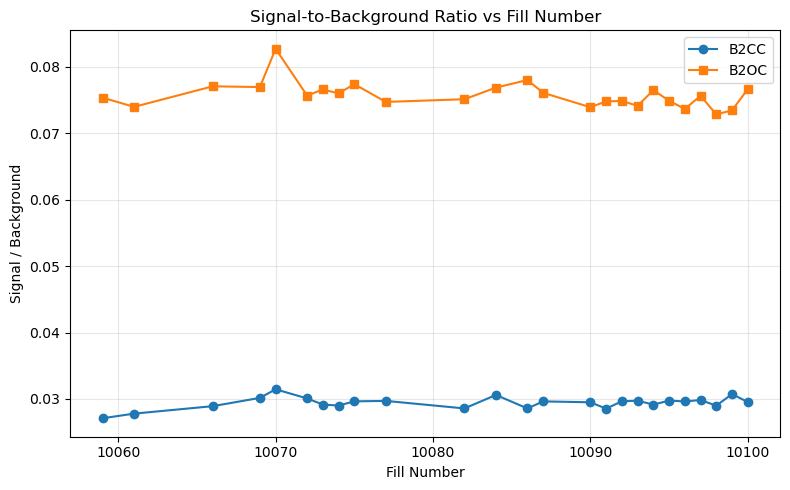

Also saved to nsig_table.html
50


Error in <TBasket::Streamer>: The value of fNbytes is incorrect (-1379) ; trying to recover by setting it to zero
Error in <TBranch::GetBasket>: File: ./data/block5_analysis/2024_B2CC_B5_F10090.root at byte:30837706, branch:mean, entry:0, badread=1, nerrors=4, basketnumber=0


In [14]:
import os, re, glob, math
import ROOT as r
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Regex parsers 

_CAT_RE  = re.compile(r"(B2OC|B2CC)", re.IGNORECASE)
_FILL_RE = re.compile(r"F(\d+)", re.IGNORECASE)

def parse_cat_fill(path: str) -> tuple[str, int]:
    """Extract category (B2OC/B2CC) and fill number from filename."""
    fname = os.path.basename(path)
    mcat  = _CAT_RE.search(fname)
    mfill = _FILL_RE.search(fname)
    if not mcat or not mfill:
        raise ValueError(f"Cannot parse category/fill from: {fname}")
    return mcat.group(1).upper(), int(mfill.group(1))

# ROOT helpers

def get_nsig(tf: r.TFile) -> float:
    """Extract nsig value from 'fit_results' TTree (first entry)."""
    tr = tf.Get("fit_results")
    if not tr or not isinstance(tr, r.TTree):
        raise RuntimeError("TTree 'fit_results' not found")
    if not tr.GetListOfBranches().FindObject("nsig"):
        raise RuntimeError("Branch 'nsig' not found in 'fit_results'")
    if tr.GetEntries() < 1:
        raise RuntimeError("'fit_results' has no entries")
    tr.GetEntry(0)
    return float(getattr(tr, "nsig"))

def get_total_entries(tf: r.TFile, category: str) -> int:
    """Return total entries in the main decay tree (ST-b2oc or ST-b2cc)."""
    tree_name = "ST-b2oc" if category == "B2OC" else "ST-b2cc"
    tr = tf.Get(tree_name)
    if not tr or not isinstance(tr, r.TTree):
        raise RuntimeError(f"TTree '{tree_name}' not found")
    return int(tr.GetEntries())

#  Data handling

def process_files(file_paths) -> tuple[dict, pd.DataFrame]:
    """
    Process ROOT files and build:
      - results_dict: { "CAT_Fill" : nsig }
      - df: DataFrame with category, fill, nsig, total, background, ratio
    """
    paths = sorted(glob.glob(file_paths)) if isinstance(file_paths, str) else list(file_paths)
    results_dict, rows = {}, []

    for p in paths:
        if not os.path.isfile(p):
            print(f"[WARN] Missing file: {p}")
            continue
        try:
            cat, fill = parse_cat_fill(p)
        except Exception as e:
            print(f"[WARN] {e} (skip)")
            continue

        tf = r.TFile.Open(p)
        if not tf or tf.IsZombie():
            print(f"[WARN] Cannot open: {p}")
            continue

        nsig, tot = math.nan, math.nan
        try:
            nsig = get_nsig(tf)
        except Exception as e:
            print(f"[WARN] {os.path.basename(p)}: {e}")
        try:
            tot = get_total_entries(tf, cat)
        except Exception as e:
            print(f"[WARN] {os.path.basename(p)}: {e}")
        tf.Close()

        background = (tot - nsig) if (pd.notnull(tot) and pd.notnull(nsig)) else math.nan
        ratio = nsig / background if (isinstance(background, (int,float)) and background > 0) else math.nan

        key = f"{cat}_F{fill}"
        results_dict[key] = nsig

        rows.append({
            "category": cat,
            "fill": fill,
            "key": key,
            "nsig": nsig,
            "total_entries": tot,
            "background": background,
            "nsig_over_background": ratio,
            "file": os.path.basename(p),
        })

    df = (pd.DataFrame(rows)
            .sort_values(["category","fill"])
            .reset_index(drop=True))
    return results_dict, df

# Visualization

def show_pretty_table(df: pd.DataFrame, title="Signal vs Background per Fill & Category", save_html="nsig_table.html"):
    """
    Build a table showing:
      - Category, Fill Number, Total Entries, Signal Events, Signal/Background.
    Saves to HTML and returns a Styler for display.
    """
    if df.empty:
        print("No rows to display.")
        return None

    disp = (df[["category", "fill", "total_entries", "nsig", "nsig_over_background"]]
              .copy()
              .sort_values(["fill", "category"]))
    disp = disp.rename(columns={
        "category": "Category",
        "fill": "Fill Number",
        "total_entries": "Total Entries",
        "nsig": "Signal Events",
        "nsig_over_background": "Signal / Background",
    })

    fmt = {
        "Fill Number": "{:d}".format,
        "Total Entries": lambda x: f"{int(x):,}" if pd.notnull(x) else "NaN",
        "Signal Events": lambda x: f"{x:,.0f}" if pd.notnull(x) else "NaN",
        "Signal / Background": lambda x: f"{x:.6f}" if pd.notnull(x) else "NaN",
    }

    styler = (disp.style
        .hide(axis="index")
        .set_caption(title)
        .format(fmt)
        .set_properties(**{
            "text-align": "center",
            "font-family": "Inter, Segoe UI, Roboto, Arial, sans-serif",
            "font-size": "13.5px",
            "padding": "6px 10px",
        })
        .set_table_styles([
            {"selector": "table",
             "props": [("border-collapse", "separate"),
                       ("border-spacing", "0"),
                       ("border", "1px solid #e5e7eb"),
                       ("border-radius", "10px"),
                       ("box-shadow", "0 2px 6px rgba(0,0,0,0.05)")]},
            {"selector": "caption",
             "props": [("caption-side", "top"),
                       ("text-align", "left"),
                       ("font-weight", "600"),
                       ("font-size", "16px"),
                       ("padding", "8px 2px 10px 2px")]},
            {"selector": "th",
             "props": [("background-color", "#0ea5e9"),
                       ("color", "white"),
                       ("text-align", "center"),
                       ("font-weight", "700"),
                       ("padding", "8px 10px"),
                       ("border-bottom", "1px solid #e5e7eb")]},
            {"selector": "td",
             "props": [("border-bottom", "1px solid #f1f5f9")]},
            {"selector": "tbody tr:nth-child(odd)",
             "props": [("background-color", "#f8fafc")]},
            {"selector": "tbody tr:hover",
             "props": [("background-color", "#eef6ff")]},
        ])
        .background_gradient(
            subset=["Signal / Background"],
            cmap="Blues",
            vmin=disp["Signal / Background"].min(skipna=True),
            vmax=disp["Signal / Background"].max(skipna=True),
        )
    )

    if save_html:
        html = styler.to_html()
        with open(save_html, "w", encoding="utf-8") as f:
            f.write(html)
        print(f"Saved styled table to: {save_html}")

    return styler

def plot_signal_background(df: pd.DataFrame):
    """
    Line plot of Signal/Background ratio vs Fill, separated by category.
    """
    df_plot = df.dropna(subset=["nsig_over_background"])
    df_b2cc = df_plot[df_plot["category"] == "B2CC"]
    df_b2oc = df_plot[df_plot["category"] == "B2OC"]

    plt.figure(figsize=(8,5))
    plt.plot(df_b2cc["fill"], df_b2cc["nsig_over_background"],
             marker='o', linestyle='-', label="B2CC")
    plt.plot(df_b2oc["fill"], df_b2oc["nsig_over_background"],
             marker='s', linestyle='-', label="B2OC")

    plt.xlabel("Fill Number")
    plt.ylabel("Signal / Background")
    plt.title("Signal-to-Background Ratio vs Fill Number")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Main routine 

if __name__ == "__main__":
    files = "./data/block5_analysis/2024_*_B5_F*.root"
    results_dict, df = process_files(files)
    print("Collected nsig values:\n", results_dict)

    styler = show_pretty_table(df, title="Signal/Background by Fill (B2OC & B2CC)",
                               save_html="./data/block5_analysis/outputs/nsig_table.html")
    if styler is not None:
        display(styler)  

    plot_signal_background(df)
    print("Also saved to nsig_table.html")
    print(len(df))


# **IV. Splitting Block 5 and comparison of sWeighted histograms**


Signal/Background analysis (B2OC/B2CC).

- Perform mass fits of B⁺ decays (B2OC/B2CC) using extended models (2 Crystal Balls + exponential).
- Save fit results as PNGs.
- Compute event by event signal sWeights via RooStats::SPlot and map them back to tree entries.
- Rewrite original ROOT files with a new branch sw_sig for the sWeights, keeping backups.
- For problematic cases (e.g. B2OC B5A), apply two-stage minimization with Gaussian priors for stability.
- Generate interactive, sWeighted and normalized histograms for all numeric scalar branches (except mass) across files using Plotly.

In [8]:
import os
import re
import math
import shutil
from array import array
import ROOT as r
from ROOT import RooFit, RooStats

FILES = [
    r"./data/block5_analysis/2024_B2CC_B5A.root",
    r"./data/block5_analysis/2024_B2CC_B5B.root",
    r"./data/block5_analysis/2024_B2OC_B5B.root",
]

MASS_BRANCH = "Bp_DTF_OwnPV_MASS"
WRITE_BRANCH = "sw_sig"       # name of the sWeight branch to be written
OUT_DIR = str(DIR_FITS)       # where PNG/ROOT canvases are saved
os.makedirs(OUT_DIR, exist_ok=True)

# Fit ranges (MeV) — use full analysis window for both categories
DEFAULT_RANGE = {
    "B2CC": (5200.0, 5450.0),
    "B2OC": (5200.0, 5450.0),
}

# Flags
SAFE_MODE = True     # single threaded RooFit to avoid sporadic segfaults
USE_OFFSET = True    # RooFit.Offset(True) for numerical stability
BATCH_MODE = True    # True = no GUI, just save files
SAVE_ROOT_CANVAS = False  # also save canvases as .root files
PRINT_ABS = True     # print absolute file paths after saving
BACKUP = True        # keep backup copy and replace originals

if SAFE_MODE:
    NUMCPU = 1
    try:
        r.ROOT.DisableImplicitMT()
    except Exception:
        pass
else:
    r.ROOT.EnableImplicitMT(os.cpu_count() or 1)
    NUMCPU = os.cpu_count() or 1

# Minimizer & messaging
r.Math.MinimizerOptions.SetDefaultMinimizer("Minuit2")
r.Math.MinimizerOptions.SetDefaultStrategy(2)
r.Math.MinimizerOptions.SetDefaultMaxFunctionCalls(500000)
r.Math.MinimizerOptions.SetDefaultTolerance(0.001)
r.RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)

# Batch toggle (no GUI when True)
r.gROOT.SetBatch(BATCH_MODE)


# Helpers 
def category_from_name(path: str) -> str:
    """
    Infer category from the filename: returns 'B2OC' or 'B2CC'.
    """
    up = os.path.basename(path).upper()
    if "B2OC" in up:
        return "B2OC"
    if "B2CC" in up:
        return "B2CC"
    return "B2OC"

def tree_name_from_filename(path: str) -> str:
    """
    Map filename to TTree name ('ST-b2oc' or 'ST-b2cc').
    Raises if neither keyword is found.
    """
    up = os.path.basename(path).upper()
    if "B2OC" in up:
        return "ST-b2oc"
    if "B2CC" in up:
        return "ST-b2cc"
    raise RuntimeError(f"Cannot decide TTree name from {path} (need B2OC/B2CC in filename).")

def assert_file_tree_ok(path: str, tname: str):
    """
    Open the ROOT file and return (TFile, TTree) for the requested tree name.
    Raises if file is missing/corrupt or the tree is absent.
    Prints a short check line with the entry count.
    """
    if not os.path.exists(path):
        raise RuntimeError(f"File does not exist: {path}")
    tf = r.TFile.Open(path)
    if not tf or tf.IsZombie():
        raise RuntimeError(f"Cannot open ROOT file (zombie/corrupt?): {path}")
    tree = tf.Get(tname)
    if not isinstance(tree, r.TTree):
        tf.Close()
        raise RuntimeError(f"TTree '{tname}' not found in {path}")
    print(f"[check] {os.path.basename(path)} → TTree={tname}, entries={tree.GetEntries()}")
    return tf, tree

def build_model(mass: r.RooRealVar, cat: str):
    """
    Construct the mass model:
      - Signal: two Crystal Ball shapes with shared mean (left/right tails),
        combined via a fraction parameter.
      - Background: exponential.
      - Extended yields: nsig and nbkg.

    Category-specific seed values are applied to nudge the fit (B2CC vs B2OC).
    Returns (model, (mean, sigma1, sigma2, alphaL, nL, alphaR, nR, frac, c, nsig, nbkg)).
    """
    # --- signal: 2 Crystal Balls with opposite tails (shared mean)
    mean   = r.RooRealVar("mean",  "B+ mean", 5279.0, 5200.0, 5350.0)
    sigma1 = r.RooRealVar("sigma1","sigma1",  12.0,   3.0,   40.0)
    sigma2 = r.RooRealVar("sigma2","sigma2",  20.0,   5.0,   60.0)
    alphaL = r.RooRealVar("alphaL","alphaL",  1.5,    0.5,    5.0)
    nL     = r.RooRealVar("nL",    "nL",      5.0,    1.0,   20.0)
    alphaR = r.RooRealVar("alphaR","alphaR", -2.0,   -5.0,   -0.5)
    nR     = r.RooRealVar("nR",    "nR",      5.0,    1.0,   20.0)

    cbL = r.RooCBShape("cbL","left CB",  mass, mean, sigma1, alphaL, nL)
    cbR = r.RooCBShape("cbR","right CB", mass, mean, sigma2, alphaR, nR)

    frac = r.RooRealVar("frac","frac",0.5,0.0,1.0)
    sig  = r.RooAddPdf("sig","sig", r.RooArgList(cbL, cbR), r.RooArgList(frac))

    # --- background: exponential
    c    = r.RooRealVar("c","c",-0.002,-1.0,0.0)
    bkg  = r.RooExponential("bkg","bkg", mass, c)

    # --- extended yields
    nsig = r.RooRealVar("nsig","nsig", 1e5, 0.0, 1e12)
    nbkg = r.RooRealVar("nbkg","nbkg", 1e5, 0.0, 1e12)

    model= r.RooAddPdf("model","sig+bkg", r.RooArgList(sig, bkg), r.RooArgList(nsig, nbkg))

    # category-specific seeds for faster convergence
    if cat == "B2CC":
        sigma1.setVal(12.0); sigma2.setVal(20.0)
        alphaL.setVal(1.5);  nL.setVal(5.0)
        alphaR.setVal(-2.0); nR.setVal(5.0)
    else:  # B2OC
        sigma1.setVal(15.0); sigma2.setVal(30.0)
        alphaL.setVal(1.2);  nL.setVal(4.0)
        alphaR.setVal(-1.5); nR.setVal(4.0)

    model._keepalive = [cbL, cbR, sig, bkg, mean, sigma1, sigma2, alphaL, nL, alphaR, nR, frac, c, nsig, nbkg]
    for o in model._keepalive:
        try:
            r.SetOwnership(o, False)
        except Exception:
            pass

    return model, (mean, sigma1, sigma2, alphaL, nL, alphaR, nR, frac, c, nsig, nbkg)

def make_dataset(tree: r.TTree, mass: r.RooRealVar, lo: float, hi: float):
    """
    Build a RooDataSet from the TTree by reading only the mass branch, keeping
    entries with lo ≤ mass ≤ hi. Each entry contributes one unweighted event.
    Also store the entry index in a variable 'evt' so we can map sWeights back.
    """
    evt = r.RooRealVar("evt","evt", 0, 0, 1e12)
    argset = r.RooArgSet(mass, evt)
    data = r.RooDataSet("data","data", argset)

    tree.SetCacheSize(100_000_000)
    tree.SetBranchStatus("*", 0)
    tree.SetBranchStatus(MASS_BRANCH, 1)

    n = tree.GetEntries()
    miss = 0
    kept = 0
    for i in range(n):
        if tree.GetEntry(i) <= 0:
            continue
        try:
            mv = getattr(tree, MASS_BRANCH)
            mval = float(mv if not hasattr(mv, "__len__") else mv[0])
        except Exception:
            miss += 1
            continue
        if not (mval == mval and math.isfinite(mval)):
            continue
        if lo <= mval <= hi:
            mass.setVal(mval)
            evt.setVal(i)           # record original entry index
            data.add(argset)
            kept += 1

    tree.SetBranchStatus("*", 1)
    print(f"[check] dataset entries in [{lo},{hi}] = {kept} (skipped {miss} unreadable rows)")
    if kept == 0:
        raise RuntimeError("Dataset is empty in chosen mass window.")
    return data

def write_sw_branch_atomic_replace(path: str, tname: str, weight_map: dict, new_branch: str):
    """
    Create a new file with the same contents, but the TTree `tname` gains a float branch `new_branch`
    containing the sWeight. Events not in weight_map (outside fit window) get weight 0. Then atomically
    replace the original file (backup optional). If `new_branch` already exists, this function skips adding it.
    """
    # Optional backup (only once)
    if BACKUP and not os.path.exists(path + ".bak"):
        shutil.copy2(path, path + ".bak")

    fin = r.TFile.Open(path, "READ")
    if not fin or fin.IsZombie():
        raise RuntimeError(f"Cannot reopen input for writing: {path}")

    tmp_path = path + ".tmp_with_weights.root"
    fout = r.TFile.Open(tmp_path, "RECREATE")
    if not fout or fout.IsZombie():
        fin.Close()
        raise RuntimeError(f"Cannot create temp output: {tmp_path}")

    try:
        keys = fin.GetListOfKeys() or []
        for k in keys:
            name = k.GetName()
            obj  = k.ReadObj()
            fout.cd()

            if isinstance(obj, r.TTree) and name == tname:
                src = obj

                # If branch already exists, just copy the tree as-is (idempotent)
                if src.GetListOfBranches().FindObject(new_branch):
                    print(f"[warn] Branch '{new_branch}' already exists in {os.path.basename(path)}:{tname} — keeping original, no rewrite.")
                    dst = src.CloneTree(-1)  # full copy
                    dst.Write(name)
                    continue

                # Otherwise: clone structure, add branch, and fill with per-entry weights
                dst = src.CloneTree(0)  # structure only
                buf = array('f', [0.0])
                bsw = dst.Branch(new_branch, buf, f"{new_branch}/F")

                n = src.GetEntries()
                for i in range(n):
                    src.GetEntry(i)
                    buf[0] = float(weight_map.get(i, 0.0))  # 0.0 if outside fit window
                    dst.Fill()

                dst.Write(name)  # keep the same key name
            else:
                obj.Write(name)

        fout.Write()
    finally:
        fin.Close()
        fout.Close()

    os.replace(tmp_path, path)
    print(f"[OK] Wrote '{new_branch}' into {os.path.basename(path)} (backup kept: {BACKUP})")

# Fit one file 

def fit_one_file(path: str):
    """
    Fit one file over the chosen range:
      - Build dataset within the chosen range.
      - Fit the 2CB+exp extended model with Minuit2.
      - Compute sWeights (signal/background) and build 'sw_sig' map (entry index -> weight).
      - Plot data (100 bins) and model/components.
      - Save PNG (and optionally ROOT canvas) into OUT_DIR (off-screen).
      - Print absolute paths when PRINT_ABS is True.
    Returns (png_path, weight_map, tname, (lo,hi)).
    """
    cat = category_from_name(path)
    lo, hi = DEFAULT_RANGE[cat]

    tname = tree_name_from_filename(path)
    tf, tree = assert_file_tree_ok(path, tname)

    mass = r.RooRealVar("mass","B^{+} mass [MeV/c^{2}]", (lo+hi)/2.0, lo, hi)
    data = make_dataset(tree, mass, lo, hi)
    model, params = build_model(mass, cat)
    mean, sigma1, sigma2, alphaL, nL, alphaR, nR, frac, c, nsig, nbkg = params

    fit_opts = [RooFit.Save(True), RooFit.Extended(True), RooFit.Strategy(2),
                RooFit.NumCPU(int(NUMCPU)), RooFit.PrintLevel(-1)]
    if USE_OFFSET:
        fit_opts.append(RooFit.Offset(True))
    _fitres = model.fitTo(data, *fit_opts)

    #-sWeights (signal & background); map back to original entry indices
    splot = RooStats.SPlot("sPlot", "sPlot", data, model, r.RooArgList(nsig, nbkg))
    idx_var = data.get().find("evt")  # the variable storing original entry index

    weight_map = {}
    for i in range(data.numEntries()):
        data.get(i)  # load i-th event
        idx = int(idx_var.getVal())
        # Prefer attached column if present; fall back to SPlot getter
        try:
            w = data.get(i).getRealValue("nsig_sw")
        except Exception:
            w = splot.GetSWeight(i, "nsig")
        weight_map[idx] = float(w)

    # Plot & Save
    frame = mass.frame(RooFit.Title(os.path.basename(path)))
    data.plotOn(frame, RooFit.Binning(100))
    model.plotOn(frame, RooFit.LineColor(r.kBlue))
    model.plotOn(frame, RooFit.Components("bkg"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen+2))
    model.plotOn(frame, RooFit.Components("cbL"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    model.plotOn(frame, RooFit.Components("cbR"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kMagenta))

    c = r.TCanvas(f"c_{re.sub(r'[^A-Za-z0-9]+','_',os.path.basename(path))}","fit",1000,750)
    c.cd()
    frame.Draw()

    base = os.path.splitext(os.path.basename(path))[0]
    png = os.path.join(OUT_DIR, f"{base}_fit.png")
    c.Print(png)  # write PNG directly (no GUI)

    rootc = None
    if SAVE_ROOT_CANVAS:
        rootc = os.path.join(OUT_DIR, f"{base}_canvas.root")
        f = r.TFile(rootc, "RECREATE"); c.Write(); f.Close()

    if PRINT_ABS:
        print(f"[OK] {path}")
        print(f"     → canvas PNG:   {os.path.abspath(png)}")
        if SAVE_ROOT_CANVAS:
            print(f"     → canvas ROOT:  {os.path.abspath(rootc)}")

    c.Close()
    tf.Close()
    return png, weight_map, tname, (lo, hi)


#  Execution 

def main():
    for fpath in FILES:
        print(f"\n=== {os.path.basename(fpath)} ===")
        try:
            png, wmap, tname, (lo, hi) = fit_one_file(fpath)
            print(f"  TTree: {tname} | fit range: [{lo:.1f}, {hi:.1f}] | weighted entries: {len(wmap)}")
            write_sw_branch_atomic_replace(fpath, tname, wmap, WRITE_BRANCH)
        except Exception as e:
            print(f"[ERROR] {os.path.basename(fpath)} -> {e}")

if __name__ == "__main__":
    main()

# Outputs:
#   - PNG canvases at:   splot_fits_b5/<basename>_fit.png
#   - ROOT canvases at:  splot_fits_b5/<basename>_canvas.root  (if SAVE_ROOT_CANVAS=True)
#   - sWeights written:  branch 'sw_sig' in the event TTree (0 for events outside the mass window)
#   - Original files are atomically replaced; backups kept as <file>.bak when BACKUP=True



=== 2024_B2CC_B5A.root ===
[check] 2024_B2CC_B5A.root → TTree=ST-b2cc, entries=23697699
[check] dataset entries in [5200.0,5450.0] = 8768437 (skipped 0 unreadable rows)
[OK] ./data/block5_analysis/2024_B2CC_B5A.root
     → canvas PNG:   /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2CC_B5A_fit.png
  TTree: ST-b2cc | fit range: [5200.0, 5450.0] | weighted entries: 8768437
[OK] Wrote 'sw_sig' into 2024_B2CC_B5A.root (backup kept: True)

=== 2024_B2CC_B5B.root ===
[check] 2024_B2CC_B5B.root → TTree=ST-b2cc, entries=18431421
[check] dataset entries in [5200.0,5450.0] = 6821229 (skipped 0 unreadable rows)
[OK] ./data/block5_analysis/2024_B2CC_B5B.root
     → canvas PNG:   /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2CC_B5B_fit.png
  TTree: ST-b2cc | fit range: [5200.0, 5450.0] | weighted entries: 6821229
[OK] Wrote 'sw_sig' into 2024_B2CC_B5B.root (backup kept: True)

===

Warning in <ROOT_TImplicitMT_DisableImplicitMT>: Implicit multi-threading is already disabled
Info in <TCanvas::Print>: png file /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2CC_B5A_fit.png has been created
Info in <TCanvas::Print>: png file /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2CC_B5B_fit.png has been created
Info in <TCanvas::Print>: png file /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2OC_B5B_fit.png has been created


## The fit for B2OC B5A didn’t work like it should. This code focuses on fixing it independently from the others. ##

 The model for the fitting stayed exactly the same (2CB + narrow Gaussian core + exponential with Gaussian priors). What changed is the following: 


**Robust seeds:** recomputed initial mean and sigma directly from data quantiles instead of relying on fixed values.

**Sideband prefit:** fitted exponential background only in the high mass sideband, then treated the slope as a prior.

**Signal core prefit:** fitted a narrow core window around the median mass to get tighter mean/sigma seeds for the signal.

**Two-stage minimization:** first let the narrow Gaussian core fraction float, then locked it after the first pass to stabilize.

**Extra minimization cycle:** ran a simplex → migrad → migrad → hesse sequence for more robust convergence.

In [11]:
import os, re, math, shutil
from array import array
import ROOT as r
from ROOT import RooFit, RooStats


FILE = r"./data/block5_analysis/2024_B2OC_B5A.root"
TREE_NAME = "ST-b2oc"
MASS_BRANCH = "Bp_DTF_OwnPV_MASS"
FIT_RANGE = (5200.0, 5450.0)
HI_SIDEBAND = (5350.0, 5450.0)
CORE_WINDOW_HALF = 45.0

WRITE_BRANCH = "sw_sig"
OUT_DIR = str(DIR_FITS)
BACKUP = True

SAVE_PLOTS = True
SAVE_ROOT_CANVAS = False
PRINT_ABS = True
PLOT_BINS = 140

# Tail priors (Gaussian constraints)
ALPHA_L0, N_L0 = 1.6, 5.0
ALPHA_R0, N_R0 = -1.6, 5.0
ALPHA_SIGMA = 0.20
N_SIGMA     = 0.70

# RooFit / threading / messages
NUMCPU = 1
r.ROOT.DisableImplicitMT()
r.Math.MinimizerOptions.SetDefaultMinimizer("Minuit2")
r.Math.MinimizerOptions.SetDefaultStrategy(2)
r.Math.MinimizerOptions.SetDefaultMaxFunctionCalls(300000)
r.Math.MinimizerOptions.SetDefaultTolerance(0.001)
r.RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)
r.gROOT.SetBatch(True)

os.makedirs(OUT_DIR, exist_ok=True)

#  helpers 
def open_tree(path: str, tname: str):
    if not os.path.exists(path): raise RuntimeError(f"File does not exist: {path}")
    f = r.TFile.Open(path)
    if not f or f.IsZombie(): raise RuntimeError(f"Cannot open ROOT file: {path}")
    t = f.Get(tname)
    if not isinstance(t, r.TTree):
        f.Close(); raise RuntimeError(f"TTree '{tname}' not found in {path}")
    return f, t

def robust_seeds(tree: r.TTree, lo, hi, max_samples=250000):
    tree.SetCacheSize(100_000_000)
    tree.SetBranchStatus("*", 0)
    tree.SetBranchStatus(MASS_BRANCH, 1)
    vals = []
    n = tree.GetEntries()
    step = max(1, n // max_samples)
    for i in range(0, n, step):
        if tree.GetEntry(i) <= 0: continue
        try:
            mv = getattr(tree, MASS_BRANCH)
            m = float(mv if not hasattr(mv, "__len__") else mv[0])
        except Exception:
            continue
        if m == m and math.isfinite(m) and (lo <= m <= hi):
            vals.append(m)
    tree.SetBranchStatus("*", 1)
    if not vals: raise RuntimeError("No mass values in chosen range.")
    vals.sort()
    mid = vals[len(vals)//2]
    q25 = vals[len(vals)//4]
    q75 = vals[(3*len(vals))//4]
    iqr = max(1.0, q75 - q25)
    sigma_seed = max(6.0, min(30.0, iqr / 1.349))
    return float(mid), float(sigma_seed)

def make_dataset(tree: r.TTree, mass: r.RooRealVar, lo: float, hi: float):
    evt = r.RooRealVar("evt","evt", 0, 0, 1e12)
    argset = r.RooArgSet(mass, evt)
    data = r.RooDataSet("data","data", argset)

    tree.SetCacheSize(100_000_000)
    tree.SetBranchStatus("*", 0)
    tree.SetBranchStatus(MASS_BRANCH, 1)

    kept, miss = 0, 0
    for i in range(tree.GetEntries()):
        if tree.GetEntry(i) <= 0: continue
        try:
            mv = getattr(tree, MASS_BRANCH)
            mval = float(mv if not hasattr(mv, "__len__") else mv[0])
        except Exception:
            miss += 1; continue
        if mval == mval and math.isfinite(mval) and (lo <= mval <= hi):
            mass.setVal(mval); evt.setVal(i); data.add(argset); kept += 1

    tree.SetBranchStatus("*", 1)
    if kept == 0: raise RuntimeError("Dataset is empty in fit range.")
    print(f"[dataset] kept={kept}  skipped_unreadable={miss}")
    return data

def prefit_background(data_sb, mass):
    c = r.RooRealVar("c_prefit","c_prefit",-0.002,-2.0,0.0)
    bkg = r.RooExponential("bkg_prefit","bkg_prefit", mass, c)
    _ = bkg.fitTo(data_sb, RooFit.Save(True), RooFit.PrintLevel(-1), RooFit.NumCPU(NUMCPU))
    return float(c.getVal()), max(1e-6, float(c.getError()))

def prefit_signal_core(data_core, mass, mean_seed, sigma_seed):
    mean   = r.RooRealVar("mean_prefit",  "mean_prefit",  mean_seed, mean_seed-20., mean_seed+20.)
    sigma1 = r.RooRealVar("sigma1_prefit","sigma1_prefit",sigma_seed, 4., 35.)
    sigma2 = r.RooRealVar("sigma2_prefit","sigma2_prefit",max(1.5*sigma_seed,8.), 6., 60.)
    alphaL = r.RooRealVar("alphaL_prefit","alphaL_prefit", ALPHA_L0, 0.8, 5.0)
    nL     = r.RooRealVar("nL_prefit",    "nL_prefit",     N_L0,     1.0, 20.0)
    alphaR = r.RooRealVar("alphaR_prefit","alphaR_prefit", ALPHA_R0, -5.0, -0.7)
    nR     = r.RooRealVar("nR_prefit",    "nR_prefit",     N_R0,     1.0, 20.0)
    cbL = r.RooCBShape("cbL_prefit","left CB",  mass, mean, sigma1, alphaL, nL)
    cbR = r.RooCBShape("cbR_prefit","right CB", mass, mean, sigma2, alphaR, nR)
    frac= r.RooRealVar("frac_prefit","frac_prefit",0.55,0.25,0.85)
    sig = r.RooAddPdf("sig_prefit","sig_prefit", r.RooArgList(cbL, cbR), r.RooArgList(frac))
    _ = sig.fitTo(data_core, RooFit.Save(True), RooFit.PrintLevel(-1), RooFit.NumCPU(NUMCPU))
    return dict(
        mean=float(mean.getVal()),
        sigma1=float(sigma1.getVal()),
        sigma2=float(sigma2.getVal()),
        alphaL=float(alphaL.getVal()),
        nL=float(nL.getVal()),
        alphaR=float(alphaR.getVal()),
        nR=float(nR.getVal()),
        frac=float(frac.getVal()),
    )

def build_model_with_priors(mass, seeds, c_seed, c_err):
    # core mean/widths
    mean   = r.RooRealVar("mean","mean", seeds["mean"],  seeds["mean"]-20., seeds["mean"]+20.)
    sigma1 = r.RooRealVar("sigma1","sigma1", seeds["sigma1"], 3.5, 40.)
    sigma2 = r.RooRealVar("sigma2","sigma2", seeds["sigma2"], 5.0, 80.)

    # narrow Gaussian core
    sigma0_seed = max(2.5, 0.6*seeds["sigma1"])
    sigma0 = r.RooRealVar("sigma0","sigma0", sigma0_seed, 2.0, 8.0)
    gcore  = r.RooGaussian("gcore","gcore", mass, mean, sigma0)

    # tails
    alphaL = r.RooRealVar("alphaL","alphaL", seeds["alphaL"], 0.7, 5.0)
    nL     = r.RooRealVar("nL",    "nL",     seeds["nL"],     1.0, 20.0)
    alphaR = r.RooRealVar("alphaR","alphaR", seeds["alphaR"], -5.0, -0.7)
    nR     = r.RooRealVar("nR",    "nR",     seeds["nR"],     1.0, 20.0)
    cbL = r.RooCBShape("cbL","left CB",  mass, mean, sigma1, alphaL, nL)
    cbR = r.RooCBShape("cbR","right CB", mass, mean, sigma2, alphaR, nR)

    # fractions (recursive)
    f_core = r.RooRealVar("f_core","f_core", 0.06, 0.00, 0.12)
    f_cbL  = r.RooRealVar("f_cbL","f_cbL",   max(0.10, min(0.70, seeds.get("frac",0.5))), 0.05, 0.90)
    sig = r.RooAddPdf("sig","sig", r.RooArgList(gcore, cbL, cbR), r.RooArgList(f_core, f_cbL), True)

    # background with sideband prior
    c   = r.RooRealVar("c","c", c_seed, c_seed-0.01, c_seed+0.0)
    bkg = r.RooExponential("bkg","bkg", mass, c)

    # extended
    nsig = r.RooRealVar("nsig","nsig", 1e6, 0.0, 1e12)
    nbkg = r.RooRealVar("nbkg","nbkg", 1e5, 0.0, 1e12)
    phys = r.RooAddPdf("phys","sig+bkg", r.RooArgList(sig, bkg), r.RooArgList(nsig, nbkg))

    # Gaussian priors
    c_aL = r.RooRealVar("c_alphaL_mean","", ALPHA_L0);  c_aL.setConstant(True)
    c_nL = r.RooRealVar("c_nL_mean",    "", N_L0);      c_nL.setConstant(True)
    c_aR = r.RooRealVar("c_alphaR_mean","", ALPHA_R0);  c_aR.setConstant(True)
    c_nR = r.RooRealVar("c_nR_mean",    "", N_R0);      c_nR.setConstant(True)
    s_a  = r.RooRealVar("c_alpha_sigma","", ALPHA_SIGMA, 1e-6, 10.0); s_a.setConstant(True)
    s_n  = r.RooRealVar("c_n_sigma",    "", N_SIGMA,     1e-6, 10.0); s_n.setConstant(True)

    c_c  = r.RooRealVar("c_c_mean","", c_seed); c_c.setConstant(True)
    s_c  = r.RooRealVar("c_c_sigma","", max(0.0002, c_err), 1e-6, 1.0); s_c.setConstant(True)

    f0_mu = r.RooRealVar("f_core_mu","", 0.05); f0_mu.setConstant(True)
    f0_si = r.RooRealVar("f_core_si","", 0.05, 1e-6, 1.0); f0_si.setConstant(True)
    g_f0  = r.RooGaussian("g_f_core","", f_core, f0_mu, f0_si)

    g_aL = r.RooGaussian("g_alphaL","", alphaL, c_aL, s_a)
    g_nL = r.RooGaussian("g_nL",    "", nL,     c_nL, s_n)
    g_aR = r.RooGaussian("g_alphaR","", alphaR, c_aR, s_a)
    g_nR = r.RooGaussian("g_nR",    "", nR,     c_nR, s_n)
    g_c  = r.RooGaussian("g_c",     "", c,      c_c,  s_c)

    priors = r.RooProdPdf("priors","priors", r.RooArgList(g_aL, g_nL, g_aR, g_nR, g_c, g_f0))
    total  = r.RooProdPdf("total","phys × priors", phys, priors)

    total._keep = [phys, sig, gcore, cbL, cbR, bkg, mean, sigma0, sigma1, sigma2,
                   alphaL, nL, alphaR, nR, f_core, f_cbL, c, nsig, nbkg,
                   c_aL, c_nL, c_aR, c_nR, s_a, s_n, c_c, s_c, f0_mu, f0_si,
                   g_aL, g_nL, g_aR, g_nR, g_c, g_f0, priors]
    for o in total._keep:
        try: r.SetOwnership(o, False)
        except Exception: pass

    return total, phys, nsig, nbkg, f_core

def _draw_components(frame, pdf):
    pdf.plotOn(frame, RooFit.LineColor(r.kBlue), RooFit.NumCPU(NUMCPU))
    pdf.plotOn(frame, RooFit.Components("bkg"),
               RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen+2))
    pdf.plotOn(frame, RooFit.Components("cbL"),
               RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    pdf.plotOn(frame, RooFit.Components("cbR"),
               RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kMagenta))
    pdf.plotOn(frame, RooFit.Components("gcore"),
               RooFit.LineStyle(r.kDotted), RooFit.LineColor(r.kBlue+2))

def save_fit_pngs(base, mass, data, total_pdf):
    # Save ONLY the fit PNG (no pulls PNG)
    frame = mass.frame(RooFit.Title(base))
    data.plotOn(frame, RooFit.Binning(PLOT_BINS))
    _draw_components(frame, total_pdf)

    png   = os.path.join(OUT_DIR, f"{base}_fit.png")
    rootc = os.path.join(OUT_DIR, f"{base}_canvas.root") if SAVE_ROOT_CANVAS else None

    cfit = r.TCanvas(f"cfit_{base}","fit",1000,750)
    frame.Draw(); cfit.Update(); cfit.SaveAs(png)

    if SAVE_ROOT_CANVAS:
        tf = r.TFile(rootc, "RECREATE"); cfit.Write(); tf.Close()

    if PRINT_ABS:
        print("[plot]", os.path.abspath(png))
        if SAVE_ROOT_CANVAS and rootc: print("[plot]", os.path.abspath(rootc))
    else:
        print("[plot]", png)
        if SAVE_ROOT_CANVAS and rootc: print("[plot]", rootc)

    # keep 3-tuple signature, but second (pulls) is None
    return png, None, rootc

def compute_pulls_and_chi2(mass, data, pdf):
    frame = mass.frame(RooFit.Title("fit"))
    data.plotOn(frame, RooFit.Binning(PLOT_BINS))
    pdf.plotOn(frame, RooFit.LineColor(r.kBlue), RooFit.NumCPU(NUMCPU))
    pull_hist = frame.pullHist()
    chi2_ndf = frame.chiSquare()
    max_abs_pull = 0.0
    xbuf = array('d', [0.0]); ybuf = array('d', [0.0])
    for i in range(pull_hist.GetN()):
        pull_hist.GetPoint(i, xbuf, ybuf)
        max_abs_pull = max(max_abs_pull, abs(ybuf[0]))
    return chi2_ndf, max_abs_pull


def fit_plot_sweight(path: str, tname: str, lo: float, hi: float):
    fin, tree = open_tree(path, tname)

    mean_seed, sigma_seed = robust_seeds(tree, lo, hi)
    mass = r.RooRealVar("mass","B^{+} mass [MeV/c^{2}]", (lo+hi)/2.0, lo, hi)

    data_all = make_dataset(tree, mass, lo, hi)
    sb_lo, sb_hi = HI_SIDEBAND
    data_sb  = make_dataset(tree, mass, sb_lo, sb_hi)
    core_lo, core_hi = mean_seed - CORE_WINDOW_HALF, mean_seed + CORE_WINDOW_HALF
    data_core = make_dataset(tree, mass, max(lo, core_lo), min(hi, core_hi))

    c_seed, c_err = prefit_background(data_sb, mass)
    sig_seeds = prefit_signal_core(data_core, mass, mean_seed, sigma_seed)

    model, phys, nsig, nbkg, f_core = build_model_with_priors(mass, sig_seeds, c_seed, c_err)

    # stage 1
    nll0 = model.createNLL(data_all, RooFit.Extended(True), RooFit.Offset(True))
    m0 = r.RooMinimizer(nll0)
    m0.setStrategy(1); m0.setPrintLevel(-1)
    m0.migrad(); m0.hesse(); _ = m0.save()

    f_core.setVal(f_core.getVal()); f_core.setConstant(True)

    # stage 2
    nll = model.createNLL(data_all, RooFit.Extended(True), RooFit.Offset(True))
    minim = r.RooMinimizer(nll)
    minim.setStrategy(2); minim.setPrintLevel(-1)
    minim.simplex(); minim.migrad(); minim.migrad(); minim.hesse()
    fitres = minim.save()

    print(f"[fit] status={fitres.status()} covQual={fitres.covQual()} nsig={nsig.getVal():.1f} nbkg={nbkg.getVal():.1f}")

    chi2_ndf, max_abs_pull = compute_pulls_and_chi2(mass, data_all, model)

    base = os.path.splitext(os.path.basename(path))[0]
    png = pulls_png = rootc = None
    if SAVE_PLOTS:
        png, pulls_png, rootc = save_fit_pngs(base, mass, data_all, model)

    _ = RooStats.SPlot("sData","sData", data_all, phys, r.RooArgList(nsig, nbkg))

    w_sig_sum = 0.0; w_bkg_sum = 0.0; neg_cnt = 0; ssw2 = 0.0
    for i in range(data_all.numEntries()):
        row = data_all.get(i)
        w_sig = row.getRealValue("nsig_sw")
        w_bkg = row.getRealValue("nbkg_sw")
        w_sig_sum += w_sig; w_bkg_sum += w_bkg
        ssw2 += w_sig*w_sig
        if w_sig < 0.0: neg_cnt += 1
    neg_frac = neg_cnt / float(data_all.numEntries())
    print(f"[splot] sum(nsig_sw)={w_sig_sum:.1f}  (fit nsig={nsig.getVal():.1f})")
    print(f"[splot] sum(nbkg_sw)={w_bkg_sum:.1f}  (fit nbkg={nbkg.getVal():.1f})")
    print(f"[splot] sqrt(sum(nsig_sw^2)) = {math.sqrt(ssw2):.3f}  vs  nsig_err = {nsig.getError():.3f}")
    print(f"[splot] negative nsig_sw fraction ≈ {100*neg_frac:.2f}%")

    weight_map = {}
    for i in range(data_all.numEntries()):
        row = data_all.get(i)
        idx = int(row.getRealValue("evt"))
        w   = row.getRealValue("nsig_sw")
        weight_map[idx] = float(w)

    fin.Close()
    return weight_map, png, rootc, pulls_png

def write_sw_branch_replace(path: str, tname: str, weight_map: dict, new_branch: str):
    if BACKUP and not os.path.exists(path + ".bak"):
        shutil.copy2(path, path + ".bak")

    fin = r.TFile.Open(path, "READ")
    if not fin or fin.IsZombie(): raise RuntimeError(f"Cannot reopen: {path}")
    tmp_path = path + ".tmp_with_weights.root"
    fout = r.TFile.Open(tmp_path, "RECREATE")
    if not fout or fout.IsZombie():
        fin.Close(); raise RuntimeError(f"Cannot create: {tmp_path}")

    try:
        keys = fin.GetListOfKeys() or []
        for k in keys:
            name = k.GetName()
            obj  = k.ReadObj()
            if k.GetClassName() == "TTree" and name == tname and isinstance(obj, r.TTree):
                src = obj
                fout.cd()
                dst = src.CloneTree(0)
                buf = array('f', [0.0])
                dst.Branch(new_branch, buf, f"{new_branch}/F")
                n = src.GetEntries()
                for i in range(n):
                    src.GetEntry(i)
                    buf[0] = float(weight_map.get(i, 0.0))
                    dst.Fill()
                dst.Write(name)
            else:
                fout.cd(); obj.Write(name)
        fout.Write()
    finally:
        fin.Close(); fout.Close()

    os.replace(tmp_path, path)
    print(f"[OK] Wrote '{new_branch}' into {os.path.basename(path)} (backup kept: {BACKUP})")

# -------- run --------
def main():
    lo, hi = FIT_RANGE
    wmap, png, rootc, _ = fit_plot_sweight(FILE, TREE_NAME, lo, hi)  # pulls PNG removed/ignored
    write_sw_branch_replace(FILE, TREE_NAME, wmap, WRITE_BRANCH)
    if PRINT_ABS:
        if png:       print("[plot]", os.path.abspath(png))
        if SAVE_ROOT_CANVAS and rootc: print("[plot]", os.path.abspath(rootc))

if __name__ == "__main__":
    main()



[dataset] kept=1696002  skipped_unreadable=0
[dataset] kept=443064  skipped_unreadable=0
[dataset] kept=920473  skipped_unreadable=0
[fit] status=0 covQual=3 nsig=516681.0 nbkg=1179321.0
[plot] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2OC_B5A_fit.png
[splot] sum(nsig_sw)=516680.4  (fit nsig=516680.4)
[splot] sum(nbkg_sw)=1179321.6  (fit nbkg=1179321.6)
[splot] sqrt(sum(nsig_sw^2)) = 1040.980  vs  nsig_err = 1040.888
[splot] negative nsig_sw fraction ≈ 49.00%
[OK] Wrote 'sw_sig' into 2024_B2OC_B5A.root (backup kept: True)
[plot] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2OC_B5A_fit.png
[#0] ERROR:Minimization -- RooMinimizer::calculateHessErrors() Error when calculating Hessian
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (1.11028e+12) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	alpha

Warning in <ROOT_TImplicitMT_DisableImplicitMT>: Implicit multi-threading is already disabled
Info in <TCanvas::Print>: png file /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/fit_plots/2024_B2OC_B5A_fit.png has been created


## This code makes interactive sWeighted, normalized hsitograms for all scalar branches (except the mass branch) from the 4 ROOT files. ##

In [13]:
import os
import re
import math
import numpy as np
import ROOT as r
import plotly.graph_objects as go

# Config
FILES = [
    r"./data/block5_analysis/2024_B2CC_B5A.root",
    r"./data/block5_analysis/2024_B2CC_B5B.root",
    r"./data/block5_analysis/2024_B2OC_B5A.root",
    r"./data/block5_analysis/2024_B2OC_B5B.root",
]
OUT_DIR = str(DIR_HISTS)
MASS_BRANCH = "Bp_DTF_OwnPV_MASS"
WEIGHT_BRANCH = "sw_sig"
MASS_RANGE = (5200.0, 5450.0)
NBINS = 60  


r.ROOT.EnableImplicitMT()  
r.gErrorIgnoreLevel = r.kWarning


# Helpers
def infer_treename(path: str) -> str:
    name = os.path.basename(path).upper()
    if "B2OC" in name:
        return "ST-b2oc"
    if "B2CC" in name:
        return "ST-b2cc"
    return ""


def list_all_branches(tree: r.TTree):
    blist = tree.GetListOfBranches()
    return [blist.At(i).GetName() for i in range(blist.GetEntries())] if blist else []


def is_numeric_leaf(tree: r.TTree, bname: str) -> bool:
    """Allow simple numeric scalar leaves only."""
    br = tree.GetBranch(bname)
    if not br:
        return False
    leaf = br.GetLeaf(bname)
    if not leaf:
        leaves = br.GetListOfLeaves()
        leaf = leaves.At(0) if leaves and leaves.GetSize() > 0 else None
    if not leaf:
        return False
    tname = leaf.GetTypeName()  # "Double_t", "Float_t", "Int_t", ...
    return tname in {
        "Double_t", "Float_t",
        "Long64_t", "ULong64_t",
        "Int_t", "UInt_t", "Short_t", "UShort_t", "Char_t", "UChar_t", "Bool_t"
    }


def sanitize_filename(name: str) -> str:
    name = re.sub(r"[^\w\-\.]+", "_", name.strip())
    return name[:200]


def stepify(edges: np.ndarray, density: np.ndarray):
    """Convert binned density into step-line arrays."""
    xs = np.repeat(edges, 2)[1:-1]
    ys = np.repeat(density, 2)
    return xs, ys


def prepare_contexts(files):
    """Open files; prepare tree and mass-filtered RDataFrame per file."""
    lo, hi = MASS_RANGE
    contexts = []
    for path in files:
        treename = infer_treename(path)
        if not treename:
            print(f"[skip] {path}: cannot infer TTree (need 'B2OC' or 'B2CC' in name).")
            continue

        f = r.TFile.Open(path)
        if not f or f.IsZombie():
            print(f"[skip] {path}: cannot open file (zombie).")
            continue

        t = f.Get(treename)
        if not t or not t.InheritsFrom("TTree"):
            print(f"[skip] {path}: TTree '{treename}' not found.")
            f.Close()
            continue

        has_mass = bool(t.GetBranch(MASS_BRANCH))
        has_w = bool(t.GetBranch(WEIGHT_BRANCH))
        if not has_mass or not has_w:
            print(f"[warn] {path}: missing required "
                  f"{'MASS ' if not has_mass else ''}{'WEIGHT ' if not has_w else ''}—skipping.")
            f.Close()
            continue

        df = r.RDataFrame(treename, path).Filter(f"{MASS_BRANCH} >= {lo} && {MASS_BRANCH} <= {hi}")

        contexts.append({
            "path": path,
            "treename": treename,
            "file": f,
            "tree": t,
            "df": df,
            "label": os.path.basename(path),
        })
    return contexts


def collect_branch_universe(contexts):
    """Union of numeric scalar branches across files, excluding mass & weight."""
    universe = set()
    for ctx in contexts:
        t = ctx["tree"]
        for b in list_all_branches(t):
            if b in (MASS_BRANCH, WEIGHT_BRANCH):
                continue
            if is_numeric_leaf(t, b):
                universe.add(b)
    return sorted(universe)


def get_hist_for_branch(df, branch: str, nbins: int):
    """
    From a mass-filtered RDataFrame, return (values, weights) for a numeric scalar branch.
    Drops NaN/inf; skips empty/constant arrays.
    """
    cols = [branch, WEIGHT_BRANCH]
    try:
        arrays = df.AsNumpy(cols)
    except Exception as e:
        print(f"    [skip] AsNumpy failed for branch '{branch}': {e}")
        return None, None

    x = arrays.get(branch, None)
    w = arrays.get(WEIGHT_BRANCH, None)
    if x is None or w is None:
        return None, None

    x = np.asarray(x)
    w = np.asarray(w)
    m = np.isfinite(x) & np.isfinite(w)
    x, w = x[m], w[m]

    if x.size == 0 or np.nanmin(x) == np.nanmax(x):
        return None, None

    return x, w


def make_plot(branch: str, traces, out_dir: str, nbins: int):
    """Create a common-bin, density-normalized step-line histogram overlay for all files."""
    xmin = min(np.min(t['x']) for t in traces)
    xmax = max(np.max(t['x']) for t in traces)
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
        return

    edges = np.linspace(xmin, xmax, nbins + 1)

    fig = go.Figure()
    for t in traces:
        counts, _ = np.histogram(t['x'], bins=edges, weights=t['w'], density=True)
        xs, ys = stepify(edges, counts)
        fig.add_trace(
            go.Scatter(
                x=xs, y=ys, mode="lines",
                name=t['label'],
                hovertemplate=f"{branch}: %{{x:.6g}}<br>density: %{{y:.6g}}<extra>{t['label']}</extra>"
            )
        )

    fig.update_layout(
        title=f"{branch} — sWeighted & normalized (mass ∈ [{MASS_RANGE[0]}, {MASS_RANGE[1]}])",
        xaxis_title=branch,
        yaxis_title="density",
        template="plotly_white",
        legend_title="File",
        hovermode="x unified",
        margin=dict(l=60, r=20, t=60, b=60),
    )

    os.makedirs(out_dir, exist_ok=True)
    fname = os.path.join(out_dir, sanitize_filename(f"{branch}.html"))
    fig.write_html(fname, include_plotlyjs="cdn")
    print(f"  [saved] {fname}")


# Execution
def main():
    if len(FILES) != 4:
        print(f"[note] You provided {len(FILES)} files (expected 4). Proceeding with available ones.")

    contexts = prepare_contexts(FILES)
    if not contexts:
        print("[error] No usable files.")
        return

    branches = collect_branch_universe(contexts)
    if not branches:
        print("[error] No numeric scalar branches found to plot.")
        return

    print(f"[info] Will produce {len(branches)} HTML histograms in '{OUT_DIR}/'")

    for b in branches:
        print(f"\n[branch] {b}")
        traces = []
        for ctx in contexts:
            if not is_numeric_leaf(ctx["tree"], b):
                print(f"    {ctx['label']}: missing/non-numeric → skip")
                continue
            x, w = get_hist_for_branch(ctx["df"], b, NBINS)
            if x is None:
                print(f"    {ctx['label']}: no data (empty/constant/unreadable) → skip")
                continue
            traces.append({"label": ctx["label"], "x": x, "w": w})

        if len(traces) == 0:
            print("    No usable data from any file. Skipping plot.")
            continue

        make_plot(b, traces, OUT_DIR, NBINS)

    for ctx in contexts:
        try:
            ctx["file"].Close()
        except Exception:
            pass

    print("\n[done] Open the HTML files in the folder:", OUT_DIR)


if __name__ == "__main__":
    main()


[info] Will produce 62 HTML histograms in '/Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/'

[branch] Bp_BPVIPCHI2
  [saved] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/Bp_BPVIPCHI2.html

[branch] Bp_DTF_OwnPV_CHI2DOF
  [saved] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/Bp_DTF_OwnPV_CHI2DOF.html

[branch] Bp_DTF_OwnPV_CTAU
  [saved] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/Bp_DTF_OwnPV_CTAU.html

[branch] Bp_DTF_OwnPV_CTAUERR
  [saved] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/Bp_DTF_OwnPV_CTAUERR.html

[branch] Bp_DTF_OwnPV_FD
  [saved] /Users/yasinghasemi/Documents/CERN/Bplus_TimeStability_LHCb/data/block5_analysis/outputs/histograms/Bp_DTF_OwnPV_FD.html

[branch] Bp_M
  [saved] /Users/yasinghasemi/Documen